# Keilegavlen et. al. (2017) mechanics experiment
This notebook will reproduce the Numerical Experiment provided in Keilegavlen et. al. (2017).

## Numerical setup
Consider a unit square with a heterogenity in the upper right corner, defined by
\begin{equation}
\chi_{2D} (x,y) =
\begin{cases}
1, \quad \min (x,y) > 1/2 \\
0, \quad \text{otherwise}
\end{cases}
\end{equation}
The material parameters are the following: $\mu = (1 - \chi_{2D}) + \kappa \chi_{2D}$ and $\lambda = \alpha \mu$. \
In this case, higher values of $\alpha$ implies a more incompressible material. \
The paper presents the analytical solution as

\begin{equation}
\boldsymbol{u} (x,y) =
\begin{bmatrix}
(x-0.5)^2 (y-0.5)^2 \\
-\frac{2}{3} (x-0.5)(y-0.5)^3
\end{bmatrix}
/ ((1 - \chi_{2D}) + \kappa \chi_{2D})
\end{equation}

Furthermore, in the solution shown in Figure 3, $\kappa = 1$.

## Code setup

In [59]:
import porepy as pp
import scipy.sparse as sps
import numpy as np

Define parameters

In [60]:
def chi(x,y):
    if min(x,y) > 1/2:
        return 1
    return 0

def kappa():
    return 2

def Mu(x,y):
    return (1-chi(x,y)) + kappa()*chi(x,y)
    #return 1 + chi(x,y)*(kappa()-1)

def Lam(x,y, alpha=1):
    return alpha * Mu(x,y)

Define analytical solution

In [61]:
def uexact(x,y):
    den = 1 - chi(x,y) + kappa() * chi(x,y)
    
    ux = ((x-0.5)**2 * (y-0.5)**2) / den
    uy = (-(2/3) * (x-0.5) * (y-0.5)**3) / den
    
    return np.array((ux,uy))

Create grid \
By the visualization, we should have 8 cells in each direction.

In [62]:
n = 32
physdims = [1,1]
g = pp.CartGrid([n,n], physdims=physdims)
g.compute_geometry()

Next, compute $\mu$ and $\lambda$ in each cell.

In [63]:
cell_centers_2D = g.cell_centers.T[:,:2]
mu = np.array([Mu(*x) for x in cell_centers_2D])
lam = np.array([Lam(*x) for x in cell_centers_2D])

Compute the stiffness matrix

In [64]:
C = pp.FourthOrderTensor(mu, lam)

Boundary conditions. \
According to the paper, boundary conditions are determined by the analytical solution.

In [65]:
# Boundary type
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
labels = np.array(['dir']*b_faces.size)

bc = pp.BoundaryConditionVectorial(g, b_faces, labels)

# Boundary values
bc_val = np.zeros((g.dim, g.num_faces))
face_centers = g.face_centers.T[:,:2][b_faces]
bc_val[:, b_faces] = np.array([uexact(*x) for x in face_centers]).T
bc_val = bc_val # * g.face_areas 
bc_val = bc_val.ravel('F')

Body forces. \
According to the paper, "the body force [...] is found by taking the divergence of the stress". Let's do that analytically. \

We have
\begin{equation}
u(x,y) = 
\begin{bmatrix}
(x-0.5)^2(y-0.5)^2 \\
- \frac{2}{3}(x-0.5)(y-0.5)^3 \\
\end{bmatrix}
=
\begin{bmatrix}
u_{x} \\
u_{y} \\
\end{bmatrix}
\end{equation}

Then,
\begin{equation}
\nabla u =
\begin{bmatrix}
2(x-0.5)(y-0.5)^2 & 2(x-0.5)^2(y-0.5) \\
- \frac{2}{3}(y-0.5)^3 & -2 (x-0.5)(y-0.5)^2
\end{bmatrix}
=
\begin{bmatrix}
u_{xx} & u_{xy} \\
u_{yx} & u_{yy}
\end{bmatrix}
\end{equation}

Notice that $u_{xx} = - u_{yy}$. \
We define the symmetric strain as
\begin{equation}
\epsilon = \frac{\nabla u + (\nabla u)^T}{2}
=
\begin{bmatrix}
u_{xx} & u_T \\
u_T & u_{yy}
\end{bmatrix}
\end{equation}

where 
\begin{equation}
u_T = \frac{u_{xy} + u_{yx}}{2} = (x-0.5)^2(y-0.5) -\frac{1}{3}(y-0.5)^3
\end{equation}

Therefore, using the formula
\begin{equation}
\sigma = 2\mu \epsilon + \lambda \text{tr}(\epsilon) I,
\end{equation}
we see that $\text{tr}(\epsilon) = u_{xx}+u_{yy} = u_{xx}-u_{xx}=0$

Therefore $\sigma = 2\mu \epsilon$.

Then, we wish to compute $f = \nabla \cdot \sigma$.

\begin{equation}
\nabla \cdot \sigma = 
\begin{bmatrix}
u_{xx,x} + u_{T,y} \\
u_{T,x} + u_{yy,y}
\end{bmatrix}
\cdot 2\mu
\end{equation}

\begin{equation}
\nabla \cdot \sigma = 
\begin{bmatrix}
2(y-0.5)^2 + (x-0.5)^2 - (y-0.5)^2 \\
2(x-0.5)(y-0.5) - 4(x-0.5)(y-0.5) \\
\end{bmatrix} \cdot 2\mu
= \begin{bmatrix}
(y-0.5)^2 + (x-0.5)^2 \\
-2(x-0.5)(y-0.5) \\
\end{bmatrix} \cdot 2\mu
\end{equation}

In [66]:
# Try first f = 0.
#f = np.zeros(g.dim * g.num_cells)

# Compute the analytical divergence:

def div_stress(x,y):
    fc = 2*Mu(x,y)
    sx = ((x-0.5)**2 + (y-0.5)**2) * fc
    sy = -2*(x-0.5)*(y-0.5) * fc
    
    return np.array((sx, sy))

In [67]:
#div = pp.fvutils.vector_divergence(g)
#stress_exact = np.array([Stress(*x) for x in cell_centers_2D])
f_exact = np.array([div_stress(*x) for x in cell_centers_2D]).T
f = f_exact.ravel('F')


Discretize and solve the system

In [68]:
mpsa = pp.Mpsa('mechanics')

specified_parameters = {'fourth_order_tensor': C, 'source': f, 'bc': bc, 'bc_values': bc_val}
data = pp.initialize_default_data(g, {}, 'mechanics', specified_parameters)
mpsa.discretize(g, data)
A, b = mpsa.assemble_matrix_rhs(g, data)

u = sps.linalg.spsolve(A, b)


Verify the solution. \
In PorePy, u is ordered like $u = [u_{x_0}, u_{y_0}, u_{x_1}, u_{y_1}, u_{x_2}, u_{y_2}, ...]$

In [69]:
u.shape

(2048,)

In [70]:
u_2d = np.reshape(u, (g.dim, -1), order='F')
u_2dT = u_2d.T

In [71]:
u_exact_2d = np.array([uexact(*x) for x in g.cell_centers.T[:,:2]])

In [72]:
(u_2dT - u_exact_2d)/u_exact_2d

array([[ -3.64951093,  -4.21110636],
       [ -9.48472632,  -7.59583113],
       [-15.6174873 , -10.49254112],
       ...,
       [-30.94522496, -21.83370325],
       [-18.72389235, -15.73375211],
       [ -7.19480351,  -8.62406657]])

Extract the traction on the faces

In [73]:
matrix_dictionary = data[pp.DISCRETIZATION_MATRICES]['mechanics']
stress = matrix_dictionary["stress"]
bound_stress = matrix_dictionary["bound_stress"]

In [74]:
stress.shape

(4224, 2048)

In [75]:
T = stress * u + bound_stress * bc_val
T2d = np.reshape(T, (g.dim, -1), order='F')
u_b2d = np.reshape(bc_val, (g.dim, -1), order='F')

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


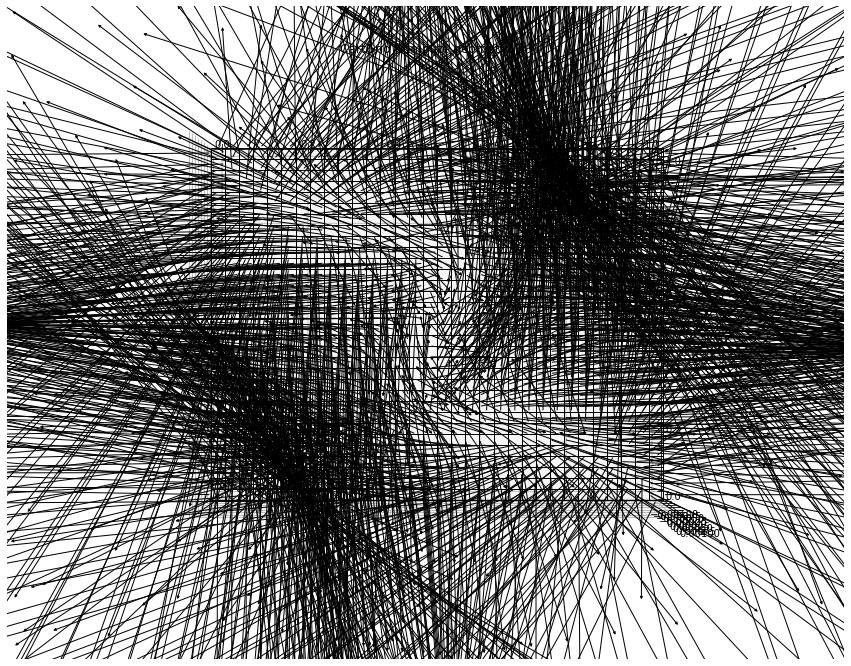

In [76]:
T = np.vstack((T2d, np.zeros(g.num_faces)))
pp.plot_grid(g, vector_value=T, figsize=(15, 12), alpha=0)

[0, 1, 0, 1]

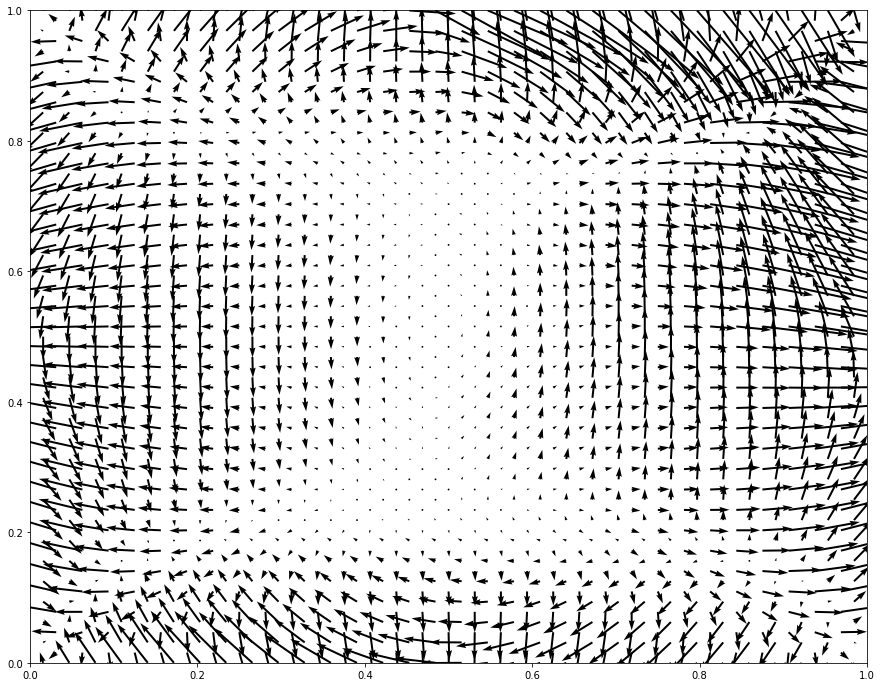

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,12))

x_pos = g.face_centers[0]
y_pos = g.face_centers[1]
ux = T2d[0]
uy = T2d[1]

ax.quiver(x_pos,y_pos,ux,uy, scale=50)
ax.axis([0,1,0,1])

[0, 1, 0, 1]

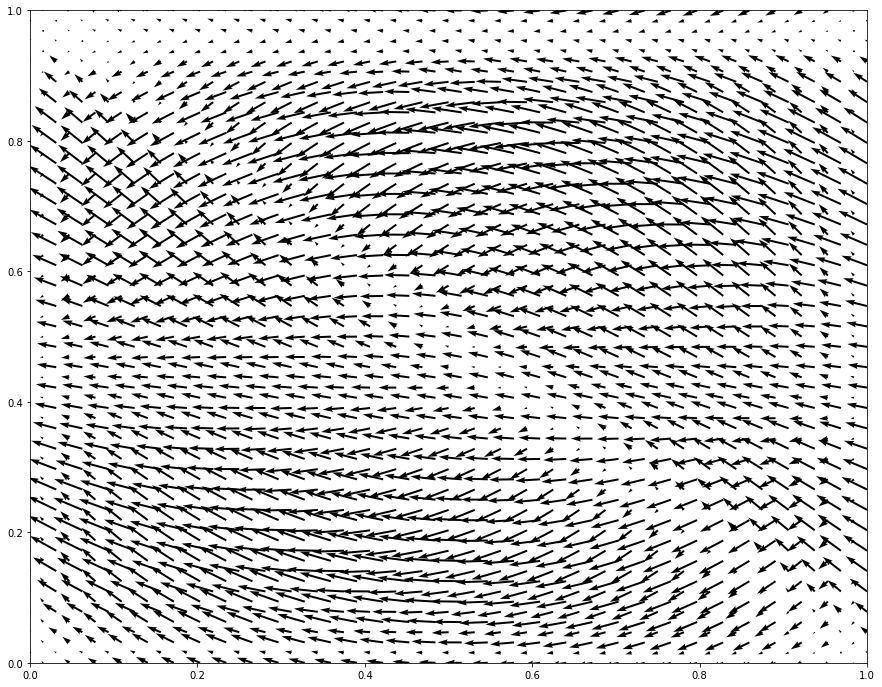

In [95]:
# quiver plot of displacements
fig2, ax2 = plt.subplots(figsize=(15,12))

x2 = g.face_centers[0]
y2 = g.face_centers[1]
ux2 = u_2d[0]
uy2 = u_2d[1]

ax2.quiver(x2,y2,ux2,uy2, scale=150)
ax2.axis([0,1,0,1])

[0, 1, 0, 1]

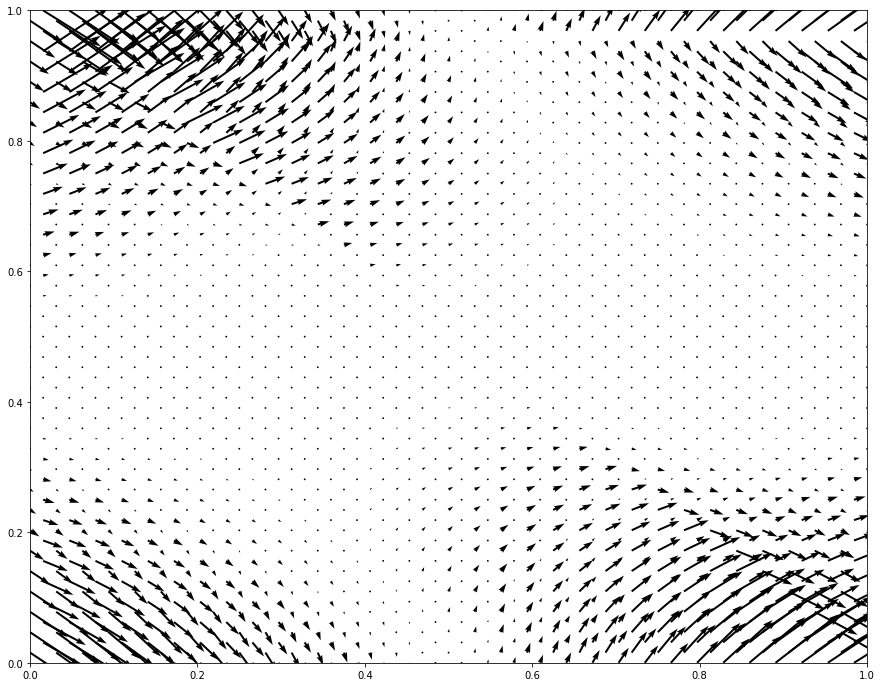

In [104]:
# exact solution u
fig3, ax3 = plt.subplots(figsize=(15,12))

x3 = g.face_centers[0]
y3 = g.face_centers[1]
ux3 = u_exact_2d.T[0]
uy3 = u_exact_2d.T[1]

ax3.quiver(x3,y3,ux3,uy3, scale=.7)
ax3.axis([0,1,0,1])

In [97]:
u_exact_2d.T

array([[ 0.05504614,  0.04817253,  0.04175717, ...,  0.02087858,
         0.02408627,  0.02752307],
       [-0.03669743, -0.03432985, -0.03196228, ..., -0.01598114,
        -0.01716493, -0.01834871]])